In [160]:
# DATA Segment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scaler import StandardScalerLSTM

SEQ_LEN = 8
BATCH_SIZE = 16
FEATURE_SIZE = 12

In [161]:
# Check if CUDA (GPU support) is available
device = 'cpu'
if torch.cuda.is_available():
    print("CUDA is available! You can use the GPU.")
    device = 'cuda'
else:
    print("CUDA is not available. You'll be using CPU.")


CUDA is available! You can use the GPU.


In [162]:
data_df = pd.read_csv("data/final_dataset.csv")

data_df = data_df.drop(['Date'], axis=1)
data_df = data_df.iloc[1900:,:]
data = np.nan_to_num(np.array(data_df, dtype=np.float32))

# ====================== Scaler ========================

# Scaler
minmax_scaler = StandardScalerLSTM(batch_size=BATCH_SIZE, sequence_length=SEQ_LEN, feature_size=FEATURE_SIZE,device=device)
minmax_scaler.fit(data)

# ====================== Scaler ========================
def create_sequence(data,seq_len):
    xs = []
    ys = []
    for i in range(len(data)-seq_len-1):
        x = data[i:(i+seq_len),:]
        # print(x.shape)
        y = data[i+seq_len,0]
        xs.append(x)
        ys.append(y)
    return np.array(xs),np.array(ys)

inputs , targets = create_sequence(data,SEQ_LEN)
inputs=torch.from_numpy(inputs);targets=torch.from_numpy(targets)

In [163]:
# split the input data into train and test data
train_size = int(0.9 * len(inputs))
test_size = len(inputs) - train_size
train_inputs, test_inputs = inputs[:train_size], inputs[train_size:]
train_targets, test_targets = targets[:train_size], targets[train_size:]
print(train_inputs.shape, test_inputs.shape)

torch.Size([3542, 8, 12]) torch.Size([394, 8, 12])


In [164]:

# ====================== Model ======================== 
class PricePredictor(nn.Module):
    def __init__(self,scaler,batch_size, input_size=12, hidden_layer_size=150, time_segment=5, output_size=1):
        super().__init__()
        self.scaler = scaler
        self.hidden_layer_size = hidden_layer_size
        self.time_segment_length = time_segment
        self.lstm = nn.LSTM(input_size, hidden_layer_size,batch_first=True) # N x L x input_size(12)
        self.linear = nn.Linear(hidden_layer_size, output_size) # N x L x output_size(1)
        self.ReLU = nn.ReLU()
        # cell double is zeros vector of shape ((1, batch_size, hidden_layer_size), (1, batch_size, hidden_layer_size))
        self.cell_double =   (torch.zeros(1,batch_size,hidden_layer_size,requires_grad=False).to(device),
                              torch.zeros(1,batch_size,hidden_layer_size,requires_grad=False).to(device))
        self.remember = False 

    def forward(self, input_seq):
        '''
            input : N x L x input_size
            ouput : N x output_size
        '''
        input_seq = self.scaler(input_seq)

        if self.remember:
            output,self.cell_double = self.lstm(input_seq,self.cell_double) # N x L x hidden_layer_size
        else:
            output,_ = self.lstm(input_seq) # N x L x hidden_layer_size
        output = self.ReLU(output)
        self.cell_double = (self.cell_double[0].detach(),self.cell_double[1].detach())
        predictions = self.linear(output[:,-1,:].squeeze()) # N x output_size
        predictions = self.scaler.inverse_transform(predictions)
        return predictions

# ====================== Model ========================

In [165]:
def early_stopping(losses, patience=3):
    return patience < len(losses) and all([losses[-i-1] > losses[-i-2] for i in range(patience)])


/home/rahulkumar/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Test loss: 10999.03515625
Test loss: 7987.00292969
Test loss: 4541.50244141
Test loss: 3969.32983398
Test loss: 3458.95629883
Test loss: 3102.89501953
Test loss: 2998.44458008
Test loss: 2877.07104492
Test loss: 2793.84497070
Test loss: 2674.35498047
Test loss: 2596.57958984
Test loss: 2533.83496094
Test loss: 2515.51269531
Test loss: 2463.44360352
Test loss: 2474.16137695
Test loss: 2455.61376953


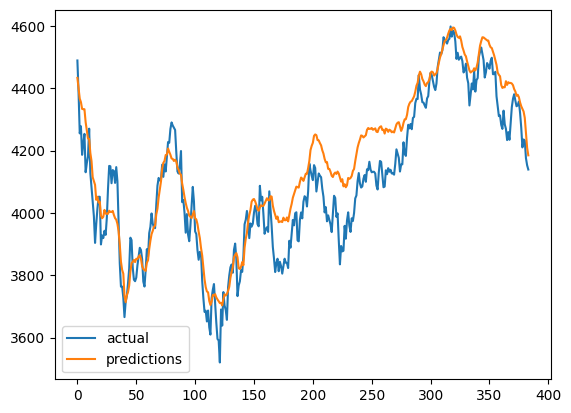

In [166]:
train_dataset = TensorDataset(train_inputs, train_targets)
test_dataset = TensorDataset(test_inputs, test_targets)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


model = PricePredictor(minmax_scaler,BATCH_SIZE).to(device)
# loss_function = nn.MSELoss()
loss_function = nn.L1Loss()
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01)

epochs = 80
test_losses = []

for i in range(epochs):
    for seq, targets in train_loader:
        if seq.shape[0]!=BATCH_SIZE: # if the last batch is not full
            continue
        seq, targets = seq.to(device), targets.to(device)
        optimizer.zero_grad()
        y_pred = model(seq)
        single_loss = loss_function(y_pred, targets)
        single_loss.backward()
        optimizer.step()

    if(i%5==0):
        # print the test loss
        with torch.no_grad():
            model.remember = True  # remember the last state of the cell
            test_loss_ = 0
            for seq_, targets_ in test_loader:
                if(seq_.shape[0]!=BATCH_SIZE): # if the last batch is not full
                    continue
                seq_, targets_ = seq_.to(device), targets_.to(device)
                y_pred_test = model(seq_)
                test_loss_ += loss_function(y_pred_test, targets_)
                # print(y_pred_test.shape)
            print(f'Test loss: {test_loss_.item():10.8f}')
            test_losses.append(test_loss_.item())
            if early_stopping(test_losses, patience=3):
                break 
            model.remember = False # forget the last state of the cell for further training
    

# ====================== Plot ========================
model.remember = True
actual_prices = []
predictions = []
with torch.no_grad():
    test_loss = 0
    for seq, targets in test_loader:
        seq, targets = seq.to(device), targets.to(device)
        if seq.shape[0]!=BATCH_SIZE: # if the last batch is not full
            continue
        y_pred = model(seq)
        targets = targets.cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        actual_prices.extend(targets.flatten())
        predictions.extend(y_pred.flatten())
    


actual_prices = np.array(actual_prices)
predictions = np.array(predictions)
x = np.arange(len(actual_prices))

plt.plot(x,actual_prices, label="actual")
plt.plot(x,predictions, label="predictions")
plt.legend()
plt.show()
